# Tabular Playground Series Jan 2022

In [1]:
# Installing the modules

!pip3 install kaggle
!pip3 install prophet
!pip3 install pystan==2.19.1.1

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640314 sha256=2142d67af505a46563edf6ca1921f16a711aed596708d0eba934c313b8798dbd
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [17]:
# Required modules

import numpy as np
import pandas as pd
import seaborn as sns

from zipfile import ZipFile
from prophet import Prophet
from google.colab import files
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [3]:
# Config

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

In [4]:
# Upload the creds

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anurag1817","key":"09b66f16e6edda0614443b2a02389465"}'}

In [5]:
# Create kaggle folder

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Test the command

!kaggle competitions download -c tabular-playground-series-jan-2022

  0% 0.00/306k [00:00<?, ?B/s]
100% 306k/306k [00:00<00:00, 45.3MB/s]
  0% 0.00/64.2k [00:00<?, ?B/s]
100% 64.2k/64.2k [00:00<00:00, 4.16MB/s]
  0% 0.00/186k [00:00<?, ?B/s]
100% 186k/186k [00:00<00:00, 51.5MB/s]


In [7]:
# Extract the zip file

with ZipFile('/content/train.csv.zip', 'r') as zf:
    zf.extractall('./')

In [16]:
# Load the data

train = pd.read_csv('train.csv', index_col='row_id', parse_dates=['date'])
train.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [9]:
# Inspecting the data

train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      26298 non-null  datetime64[ns]
 1   country   26298 non-null  object        
 2   store     26298 non-null  object        
 3   product   26298 non-null  object        
 4   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.2+ MB


,num_sold
count,26298.000000
mean,387.533577
std,266.076193
min,70.000000
25%,190.000000
50%,315.000000
75%,510.000000
max,2884.000000


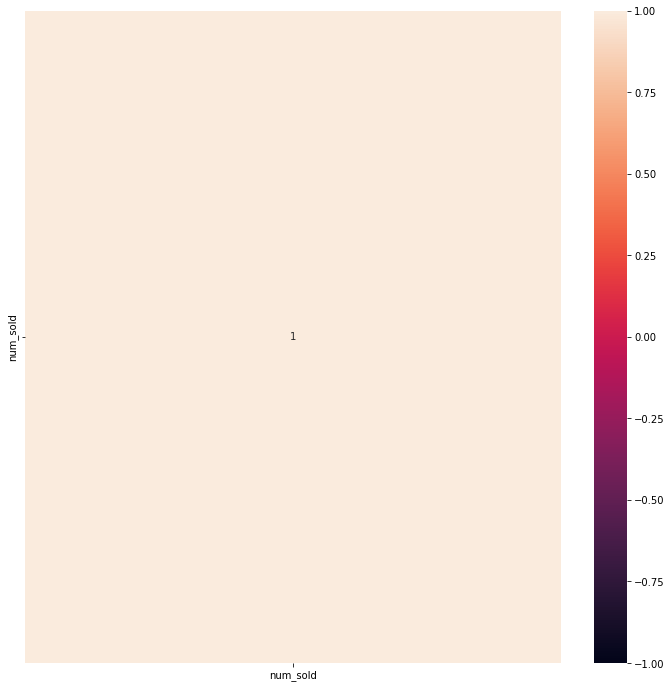

In [10]:
# Correlation matrix

sns.heatmap(train.corr(), annot=True, vmin=-1, vmax=1)

In [11]:
# Load the data

test = pd.read_csv('test.csv', index_col='row_id')
test.head()

,date,country,store,product
row_id,,,,
26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


There are no missing values, in the data.

In [12]:
# Missing values

if train.isna().any().any():
    print(train.isna().sum()/train.shape[0])
else:
    print("No Missing values")

No Missing values


In [24]:
# Renaming columns based on fbprophet

train = train.rename(columns={'date': 'ds', 'num_sold': 'y'})
test = test.rename(columns={'date': 'ds'})

## Preprocessing

In [21]:
# Encode the categorical variables

for col in ['country', 'store', 'product']:
    encoder = LabelEncoder()

    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])

## Modelling

In [22]:
# FbProphet Instantiation

model = Prophet()
model.add_regressor('country')
model.add_regressor('store')
model.add_regressor('product')
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
# Predictions

forecast = model.predict(test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,country,country_lower,country_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,product,product_lower,product_upper,store,store_lower,store_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,332.765466,280.909237,648.290347,332.765466,332.765466,133.846043,133.846043,133.846043,-24.229695,-24.229695,-24.229695,-24.229695,-24.229695,-24.229695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-29.926766,-29.926766,-29.926766,188.002503,188.002503,188.002503,0.0,0.0,0.0,466.611509
1,2019-01-01,332.765466,322.328464,671.436807,332.765466,332.765466,167.549327,167.549327,167.549327,24.229695,24.229695,24.229695,9.473589,9.473589,9.473589,-224.723012,-224.723012,-224.723012,209.966907,209.966907,209.966907,-29.926766,-29.926766,-29.926766,188.002503,188.002503,188.002503,0.0,0.0,0.0,500.314793
2,2019-01-01,332.765466,761.767223,1132.678471,332.765466,332.765466,616.995352,616.995352,616.995352,24.229695,24.229695,24.229695,458.919614,458.919614,458.919614,224.723012,224.723012,224.723012,209.966907,209.966907,209.966907,-29.926766,-29.926766,-29.926766,188.002503,188.002503,188.002503,0.0,0.0,0.0,949.760818
3,2019-01-01,332.765466,545.225906,904.305071,332.765466,332.765466,392.272340,392.272340,392.272340,24.229695,24.229695,24.229695,234.196602,234.196602,234.196602,0.000000,0.000000,0.000000,209.966907,209.966907,209.966907,-29.926766,-29.926766,-29.926766,188.002503,188.002503,188.002503,0.0,0.0,0.0,725.037805
4,2019-01-01,332.765466,113.097135,488.268610,332.765466,332.765466,-42.417580,-42.417580,-42.417580,24.229695,24.229695,24.229695,-200.493318,-200.493318,-200.493318,-224.723012,-224.723012,-224.723012,0.000000,0.000000,0.000000,-29.926766,-29.926766,-29.926766,188.002503,188.002503,188.002503,0.0,0.0,0.0,290.347886


In [30]:
# Generating output file

submission = pd.read_csv('/content/sample_submission.csv')
submission['num_sold'] = forecast.iloc[:, -1].values
submission.to_csv('output.csv', index=False)

In [31]:
# Submission

!kaggle competitions submit -c tabular-playground-series-jan-2022 -f output.csv -m "FB Prophet"

100% 155k/155k [00:03<00:00, 49.3kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022